In [1]:
%cd ..
%ls 

from ch_est_net.preloading import *
from ch_est_net.utils import *

from ch_est_net.nets import *
from ch_est_net import Trainer

from torch.fft import fft, ifft, fftshift, ifftshift

%load_ext autoreload
%autoreload 2

import torch
print(torch.__version__)

import wandb
USE_WANDB = False

/home/alex/GitHub/ML_for_channel_estimation
ch_est_net/        lista_beam_net.pt  output.svg        torchvix-sample
config_beams.yaml  model_image        __pycache__/      torchvix-sample.png
config.yaml        model_image.png    README.md         wandb/
data.h5            Notebooks/         requirements.txt  zero_150.pt
DMRS_signal/       one.pt             results/          zero.pt
1.10.1


In [2]:
cfg, dataL, dataS, device, deviceType, dtype, file, ml_default, onePilotFolder, path ,preload, print_function, scen0, Scenario = crazy_preloader()

Using CPU

Preload data: OK


In [3]:
if USE_WANDB == True:
    wandb.init(project="ML_for_channel_estimation", entity="albly")

In [4]:
d_re, d_im, id_re, id_im = DFT_matrixes(100,100,True)
IDFT = id_re + 1j* id_im 
DFT = d_re + 1j*d_im

DFT = DFT[:48,:100]
IDFT = DFT.conj().T


In [5]:
class Tied_LAMP_Head_Layer(torch.nn.Module):
    def __init__(self, beta = 1.0, alpha = 0.02, activation_class = 'complex_soft_threshold'):
        super(Tied_LAMP_Head_Layer, self).__init__()
        
        self.beta =  nn.Parameter(torch.tensor(beta, dtype = torch.float64), requires_grad = False)
        self.alpha = nn.Parameter(torch.tensor(alpha, dtype = torch.float64), requires_grad = True)
        self.activation = getattr(ch_est_net.activation, activation_class)
        self._is_pass = False


    def forward(self, x_hat, v, y, A, B):
        if self._is_pass == False:
                
            M = torch.tensor(A.shape[0])
            assert M == 48, ''

            r = x_hat + B@v

            sigma = 1.0/torch.sqrt(M) * torch.linalg.vector_norm(v, ord=2)
            lambd = self.alpha * sigma
            x_hat = self.beta * self.activation.function(r,lambd)
            b = self.beta/M * torch.linalg.vector_norm(x_hat, ord =0)
            v = y - A@x_hat + b*v

        return x_hat, v 

    def setTrainable(self, state: bool):
        if state == True:
            self.alpha.requires_grad = True
        else:
            self.alpha.requires_grad = False
            self.alpha.grad = None

#=============================================================================

class Tied_LAMP_Layer(torch.nn.Module):
    def __init__(self, beta = 1.0, alpha = 0.02, activation_class = 'complex_soft_threshold'):
        super(Tied_LAMP_Layer, self).__init__()
        
        self.beta = nn.Parameter(torch.tensor(beta, dtype = torch.float64), requires_grad = True)
        self.alpha = nn.Parameter(torch.tensor(alpha, dtype = torch.float64), requires_grad = True)
        self.activation = getattr(ch_est_net.activation, activation_class)

        self._is_pass = False


    def forward(self, x_hat, v, y, A, B):
        if self._is_pass == False:
                
            M = torch.tensor(A.shape[0])
            #assert M == 48, ''

            r = x_hat + B@v

            sigma = 1.0/torch.sqrt(M) * torch.linalg.vector_norm(v, ord=2)
            lambd = self.alpha * sigma
            x_hat = self.beta * self.activation.function(r,lambd)
            b = self.beta/M * torch.linalg.vector_norm(x_hat, ord =0)
            v = y - A@x_hat + b*v

        return x_hat, v 

    def setTrainable(self, state: bool):
        if state == True:
            self.beta.requires_grad = True
            self.alpha.requires_grad = True
        else:
            self.beta.requires_grad = False
            self.beta.grad = None
            self.alpha.requires_grad = False
            self.alpha.grad = None


#=============================================================================

class Tied_LAMP_final(torch.nn.Module):
    def __init__(self, A, layers: int, delta = 1.0, activation_class = 'complex_soft_threshold'):
        super(Tied_LAMP_final,self).__init__()

        self.net = torch.nn.ModuleList(
            [Tied_LAMP_Layer(beta=0.1, alpha=0.1, activation_class = activation_class) for i in range(layers-1)]
        )

        self.net.insert(0, Tied_LAMP_Head_Layer(beta=1.0, alpha = 0.1))

        self.A = A 
        self.B = nn.Parameter(torch.clone(A).conj().T.detach(), requires_grad = True)
        self.M , self.N = torch.tensor(A.shape[0]), torch.tensor(A.shape[1])
        self.delta = delta

        assert self.M <= self.N, 'M assumed to be <= N'

        self.layers = layers

        self.is_save_log = False
        self.log_dict = {}


    
    def forward(self, y):
        y = y.T

        self.maximum = torch.linalg.vector_norm(y,ord = float('inf'))
        y= y/self.maximum * self.delta

        x_hat = torch.zeros(self.N, y.shape[1], dtype = self.A.dtype)
        v = y
        
        #assert list(x_hat.shape) == [512,64], 'Size is {0}'.format(list(x_hat.shape))
        #assert list(v.shape) == [48,64], 'Size is {0}'.format(list(v.shape))
        
        for num, layer in enumerate(self.net):
            x_hat, v = layer.forward(x_hat, v, y, self.A, self.B)
            
            if self.is_save_log == True:
                self.save_log(x_hat, v, num)

            
        x = self.A@x_hat

        x = x*self.maximum / self.delta

        return x.T


    def save_log(self, x_hat, v, num):
        if num == 0:
            self.log_dict['x_hat'] = []
            self.log_dict['v'] = []

        self.log_dict['x_hat'].append(x_hat)
        self.log_dict['v'].append(v)

    
    def save_var_log(self, data, label:str, num:int):
        if num == 0:
            self.log_dict[label] = []
        self.log_dict[label].append(data)

    

    def send_log_wandb(self, x_true, x_noisy):
        # TIME DOMAIN 
        plt.figure()
        plt.plot(abs(ifft(x_true[1,:], 512, norm = 'ortho'))**2, label = 'x_real')
        for idx, data in enumerate(self.log_dict['x_hat']):
            plt.plot(abs(data[:,1])**2, label = 'x_hat_{0}_layer'.format(idx))
        plt.grid()
        #plt.legend()
        plt.xlabel('Time samples')
        plt.ylabel('Power [W]')
        wandb.log({"x_hat_1_antenna":plt})

        #FREQUENCY DOMAIN
        plt.figure()
        for idx, data in enumerate(self.log_dict['v']):
            plt.plot(abs(data[:,1])**2, label = 'residual_{0}_layer'.format(idx))
        plt.grid()
        plt.xlabel('Frequency samples')
        plt.ylabel('Power [W]')
        wandb.log({"residual_1_antenna":plt})
        
        plt.figure()
        plt.subplot(1,3,1)
        plt.imshow(abs(x_noisy)**2)
        plt.subplot(1,3,2)
        plt.imshow(abs(x_true)**2)
        plt.subplot(1,3,3)
        plt.imshow(abs(x_true)**2)
        wandb.log({"images:":plt})

        # TODO Restored images


    def set_params_prev_layer(self, i:int):
        state = self.net[i-1].state_dict()

        if i ==1:
            state['beta'] = torch.tensor(0.01, dtype = torch.float64)

        self.net[i].load_state_dict(state)



    def setState(self, trainable_code, pass_code):

        c = [bool(int(d)) for d in str(trainable_code)]
        p = [bool(int(d)) for d in str(pass_code)]

        for i, module in enumerate(self.net):
            module.setTrainable(c[i])
            module._is_pass = p[i]


In [5]:
def get_batch(snr_range, ind_range, seed):
    '''
    For files ind_range add noise with snr_range and stack all realizations to single array
    --------------------------------------------------------------------------
    RETURNS:
    pilot_batch -> [Realizations ; Antennas ; Subc ; Re/Im ]
    data_batch  -> [Realizations ; Antennas ; Subc ; 12? ; Re/Im]
    pilot_batch -> [Realizations]
    --------------------------------------------------------------------------
    Realizations = len(snr_range)*len(ind_range) 
    '''

    pilot_batch = torch.tensor(())
    pilot_noisy_batch = torch.tensor(())
    data_batch = torch.tensor(())
    noise_P_batch = torch.tensor(())

    for snr in snr_range:
        for ind in ind_range:
            h_pilot, h_data = data_load(scen0, dtype = dtype, onePilotFolder = onePilotFolder,dataL=dataL, ind = ind) 
                                                  # load data
            h_pilot_noisy, _ = add_noise(h_pilot, SNR = snr,scen=scen0, dtype=dtype, seed = seed)                             # add noise to pilots
            h_data_noisy, data_noise_power = add_noise_data(h_data, SNR = snr, dtype = dtype, seed = seed)     # add noise to data

            h_pilot = h_pilot.mean(dim = 2).unsqueeze(dim = 0)                                  # mean over pilots dim and add aditional dim
            h_pilot_noisy = h_pilot_noisy.mean(dim = 2).unsqueeze(dim = 0)

            h_data_noisy = h_data_noisy.unsqueeze(dim = 0)                                      # add additional dim for
            data_noise_power = data_noise_power.unsqueeze(dim =0)

            pilot_batch = torch.cat((pilot_batch, h_pilot), dim = 0)

            pilot_noisy_batch = torch.cat((pilot_noisy_batch, h_pilot_noisy), dim = 0)
            data_batch = torch.cat((data_batch, h_data_noisy), dim = 0)
            noise_P_batch = torch.cat((noise_P_batch, data_noise_power), dim = 0)

    return pilot_batch, pilot_noisy_batch, data_batch, noise_P_batch

In [6]:
x_batch, u_batch, _, _ = get_batch(snr_range = [-12, -8, -6 , -3 ,0],
                                              ind_range = range(1, 140, 3),
                                              seed = 3)

x_test, u_test, _, _ = get_batch(snr_range = [-10, -9, -5 , -2 , -1],
                                              ind_range = range(2, 141, 3),
                                              seed = 2)

x_batch = x_batch[:,:,:,0] + 1j*x_batch[:,:,:,1]
u_batch = u_batch[:,:,:,0] + 1j*u_batch[:,:,:,1]

x_test = x_test[:,:,:,0] + 1j*x_test[:,:,:,1]
u_test = u_test[:,:,:,0] + 1j*u_test[:,:,:,1]


In [ ]:
# plt.figure(figsize=(9,6))
# plt.title("Real part of the signal on the 1st antenna", fontsize = 16)
# plt.plot(x_batch[2,1,:].real, label = 'Ideal signal', color ='red')
# plt.plot(u_batch[2,1,:].real, label = 'Noisy signal')
# plt.xlabel("Frequency samples", fontsize = 16)
# plt.ylabel("Real part of the signal", fontsize = 16)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.legend(prop={'size': 18})
# plt.grid()

In [ ]:
# plt.figure(figsize=(9,6))
# plt.title("Amplitude of the signal on the 1st antenna in the delay domain", fontsize = 16)
# plt.plot((abs(torch.fft.fftshift(torch.fft.ifft(x_batch[2,1,:], 510)))), label = 'Ideal signal', color ='red')
# plt.plot((abs(torch.fft.fftshift(torch.fft.ifft(u_batch[2,1,:], 510)))),label = 'Noisy signal')
# #plt.plot(x_batch[2,1,:].real, label = 'Ideal signal', color ='red')
# #plt.plot(u_batch[2,1,:].real, label = 'Noisy signal')
# plt.xlabel("Time samples", fontsize = 16)
# plt.ylabel("Amplitude", fontsize = 16)
# #plt.yscale('log')
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.legend(prop={'size': 18})
# plt.grid()

In [8]:
import torch
from torch.nn.functional import mse_loss
import numpy as np


def MSE(x_real, x_hat):
    '''Mean squared error generalized for complex values'''

    assert x_real.shape == x_hat.shape, 'Sizes of both values must be the same, but got {0} and {1} instead'.format(x_real.shape, x_hat.shape)
    
    if torch.is_complex(x_real):
        mse = torch.sum(torch.abs(x_real-x_hat)**2)/torch.numel(x_real)

    else:
        mse = mse_loss(x_real, x_hat)

    return mse


def train_net(data_noisy, data,  model, optimizer):
    device = "cpu"#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('Starting Training using device : ', device)

    model.to(device)
    criterion = MSE  
    n_epochs = 100
    
    train_mses = []
    test_mses = []

    for epoch in range(n_epochs):
        model.train()
        current_mse = torch.tensor(0.0 , dtype= torch.float64)
        optimizer.zero_grad() 

        # training 
        for cur_data_idx in range(data.shape[0]):
            x = data[cur_data_idx,:].type(torch.complex64).detach()
            y = data_noisy[cur_data_idx,:].type(torch.complex64).detach()

            x_hat = model(y)
            
            current_mse += criterion(x, x_hat)
        

        current_mse.backward()
        optimizer.step()
        
        train_mses.append(current_mse.item())

        print('Epoch: {0}. Train Loss : {1}.'.format(epoch, current_mse))
        del current_mse

    return model, train_mses

In [21]:
lamp = Tied_LAMP_final(DFT,7)
trainer = Trainer.Scenary_Trainer(lamp,MSE)

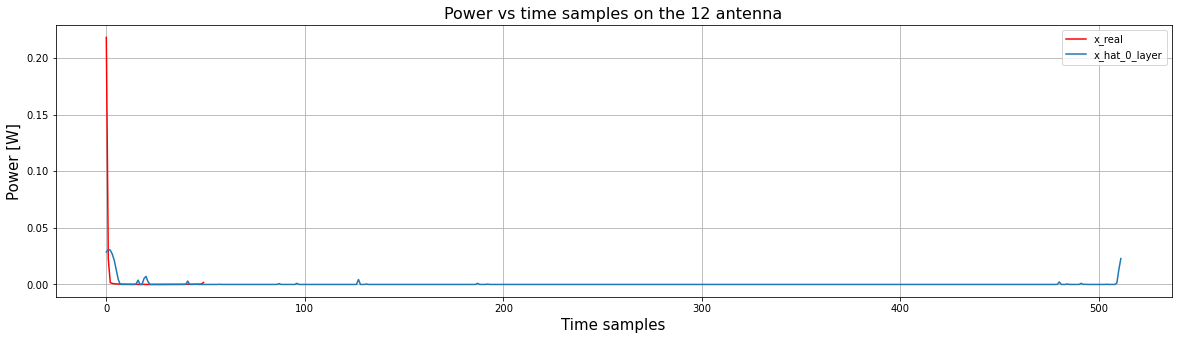

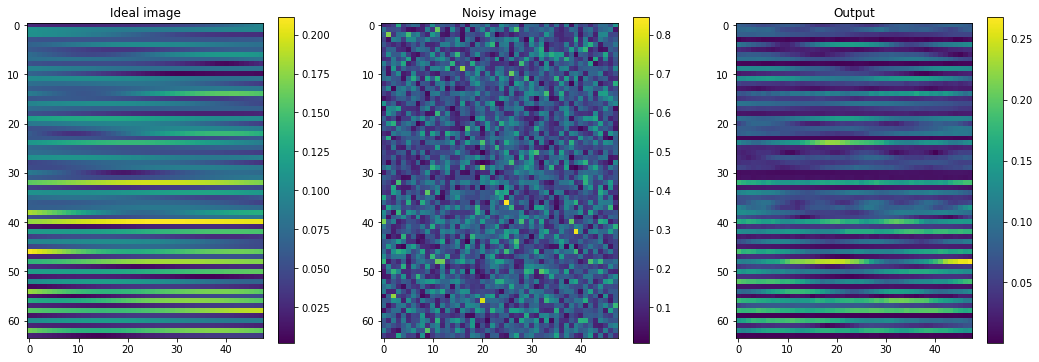

In [165]:
lamp.is_save_log = True
with torch.no_grad():
    x = x_batch[0,:].type(torch.complex64).detach()
    y = u_batch[0,:].type(torch.complex64).detach()

    g = lamp(y)

    plot_time_domain(lamp, x,y, 12)
    plot_images(x,y,g)

In [35]:
def plot_time_domain(model,x,y, antenna):

    plt.figure(figsize=(20,5))
    plt.plot(abs(ifft(x[antenna,:], 512, norm = 'ortho'))**2, label = 'x_real', color = 'red')
    #plt.plot(abs(ifft(y[antenna,:], 512, norm = 'ortho'))**2, label = 'x_noisy', color = 'black')
    for idx, data in enumerate(model.log_dict['x_hat']):
        plt.plot(abs(ifft(fft(data[:,antenna],norm = 'ortho'),n=512,norm = 'ortho'))**2, label = 'x_hat_{0}_layer'.format(idx))
    plt.legend()
    plt.grid()
    plt.xlabel('Time samples', fontsize = 15)
    plt.ylabel('Power [W]', fontsize = 15)
    plt.title('Power vs time samples on the {0} antenna'.format(antenna), fontsize = 16)
    plt.show()

def plot_images(x,y,out):    
    plt.figure(figsize = (18,6))
    plt.subplot(1,3,1)
    plt.imshow(abs(x).detach().numpy())
    plt.title('Ideal image')
    plt.colorbar()
    plt.subplot(1,3,2)
    plt.imshow(abs(y))
    plt.title('Noisy image')
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.imshow(abs(out))
    plt.title('Output')
    plt.colorbar()

In [23]:
trainer.train_with_scenary(x_batch, u_batch, x_test,u_test, 300)



 Stage  0
Epoch: 0. Train Loss :  26.68341. Test Loss:  42.59561
Epoch: 5. Train Loss :  25.42519. Test Loss:  42.59638
Epoch: 10. Train Loss :  24.93390. Test Loss:  42.92874
Epoch: 15. Train Loss :  24.70763. Test Loss:  42.69754
Epoch: 20. Train Loss :  24.67036. Test Loss:  42.66379
Epoch: 25. Train Loss :  24.63959. Test Loss:  42.68442
Epoch: 30. Train Loss :  24.61200. Test Loss:  42.70619
Epoch: 35. Train Loss :  24.58753. Test Loss:  42.69985
Epoch: 40. Train Loss :  24.58597. Test Loss:  42.69809
Epoch: 45. Train Loss :  24.58431. Test Loss:  42.69585
Epoch: 50. Train Loss :  24.58262. Test Loss:  42.69358
Epoch: 55. Train Loss :  24.58093. Test Loss:  42.69197
Epoch: 60. Train Loss :  24.58084. Test Loss:  42.69189
Epoch: 65. Train Loss :  24.58075. Test Loss:  42.69183
Epoch: 70. Train Loss :  24.58067. Test Loss:  42.69178
Epoch: 75. Train Loss :  24.58058. Test Loss:  42.69173
Epoch: 80. Train Loss :  24.58055. Test Loss:  42.69173
Epoch: 85. Train Loss :  24.58055. Tes

KeyboardInterrupt: 

In [22]:
torch.save(trainer.model.state_dict(), 'zero_150.pt')

56


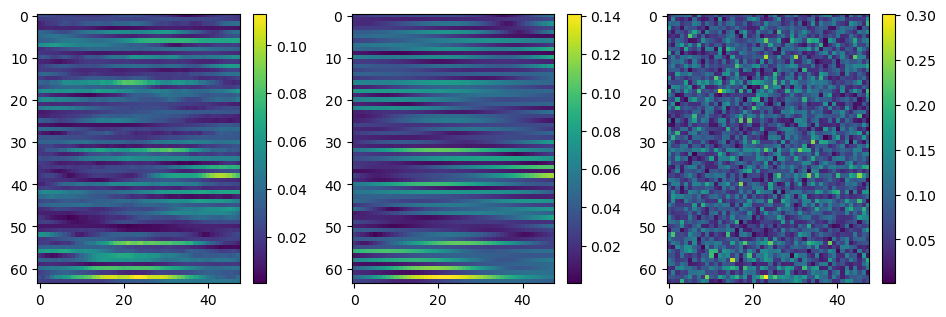

In [27]:
idx = np.random.randint(0,235)
x = x_batch[idx,:].type(torch.complex64).detach()
y = u_batch[idx,:].type(torch.complex64).detach()

x_hat = trainer.model(y)
plt.figure(figsize = (11.5,3.5))
plt.subplot(1,3,1)
plt.imshow(abs(x_hat).detach().numpy())
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(abs(x))
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(abs(y))
plt.colorbar()

print(idx)


In [ ]:
lamp2 = Tied_LAMP_final(DFT,1)

Text(0.5, 1.0, 'First layer learning')

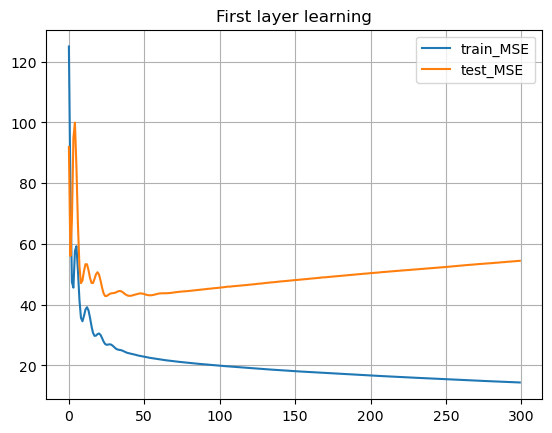

In [191]:
plt.plot(trainer.train_loss_history[:300], label = 'train_MSE')
plt.plot(trainer.test_loss_history[:300], label = 'test_MSE')
plt.grid()
plt.legend()
plt.title('First layer learning')

In [23]:
lamp2 = Tied_LAMP_final(DFT,2)
state = torch.load('zero_150.pt')

lamp2.net[0].alpha.data = state['net.0.alpha'].detach()
lamp2.net[1].alpha.data = state['net.0.alpha'].detach()

lamp2.net[1].beta.data = torch.tensor(0.0195313, dtype = torch.float64).detach()

lamp2.B.data = state['B'].detach()


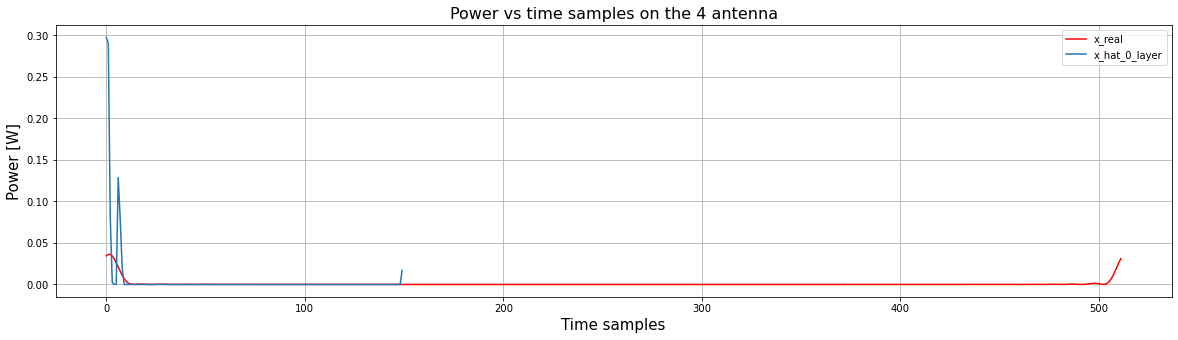

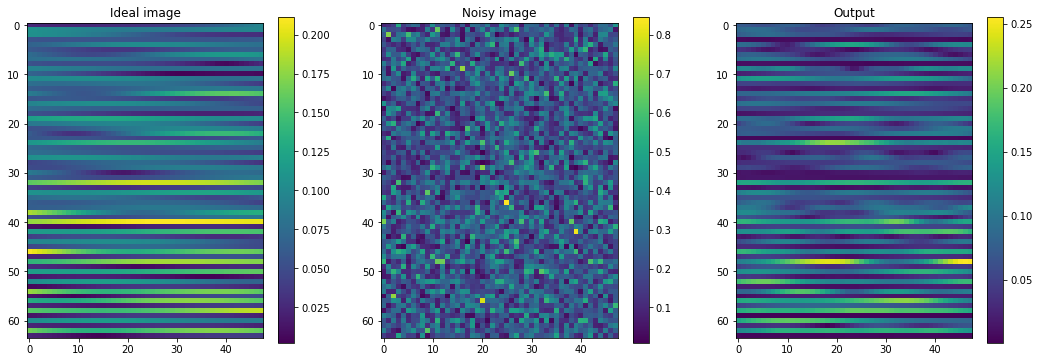

In [24]:
lamp.is_save_log = True
with torch.no_grad():
    x = x_batch[0,:].type(torch.complex64).detach()
    y = u_batch[0,:].type(torch.complex64).detach()

    g = lamp(y)

    plot_time_domain(lamp, x,y, 4)
    plot_images(x,y,g)

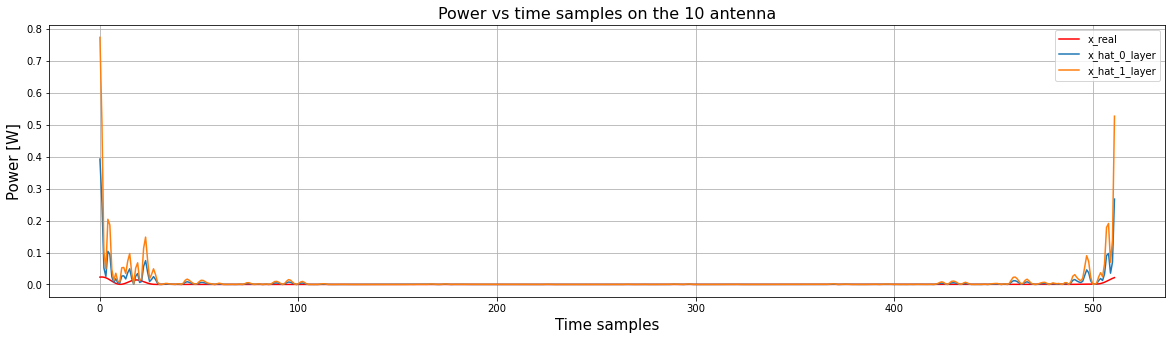

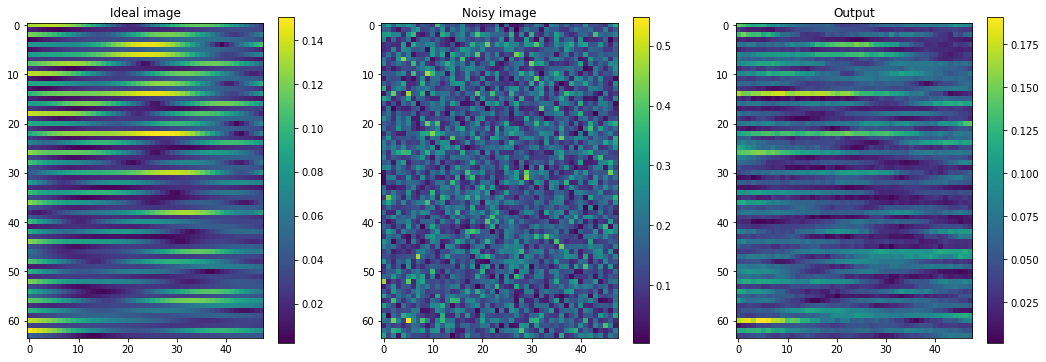

In [42]:
lamp2.is_save_log = True
with torch.no_grad():
    x = x_batch[40,:].type(torch.complex64).detach()
    y = u_batch[40,:].type(torch.complex64).detach()

    g = lamp2(y)
    

    plot_time_domain(lamp2, x,y, 10)
    plot_images(x,y,g)

tensor(0.0133)

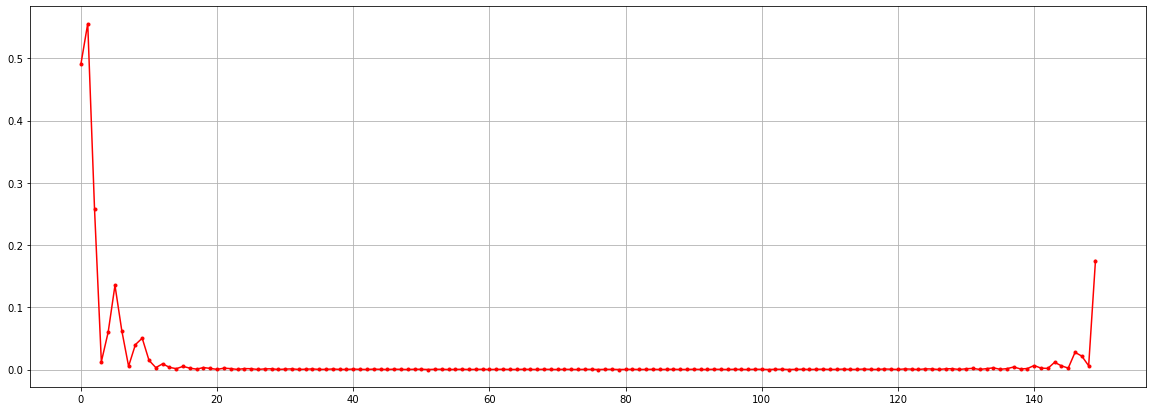

In [202]:
plt.figure(figsize=(20,7))
g = abs(ifft(x_batch[10,1,:], 150, norm = 'ortho'))**2
plt.plot(g,'.-',  label = 'x_real', color = 'red')
plt.grid()
torch.isclose(g,torch.zeros_like(g), atol=1e-5).sum()/len(g)

In [97]:
x_hat0 = lamp.log_dict['x_hat'][0]

In [89]:
x_hat2 = lamp2.log_dict['x_hat'][1]
x_hat1 = lamp2.log_dict['x_hat'][0]

In [98]:
res = DFT@x_hat0

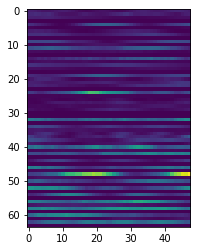

In [99]:
plt.imshow(abs(res.T)**2)

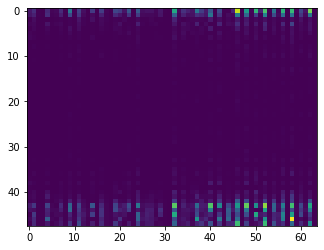

In [81]:
plt.imshow(abs(fft(x_hat2, n= 48, dim = 0 ,norm = 'ortho'))**2)

112


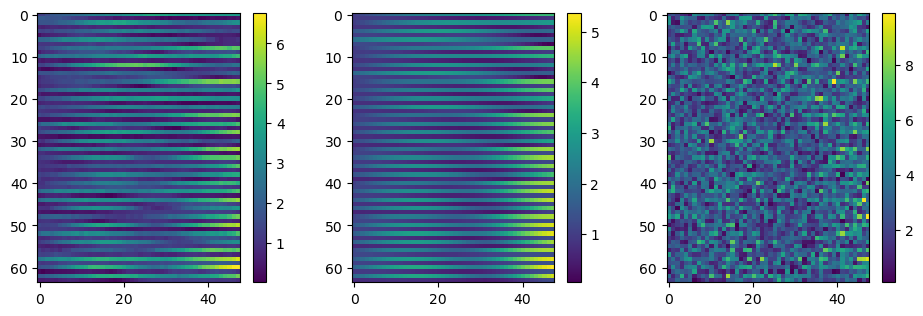

In [299]:
#idx = np.random.randint(0,235)
x = x_batch[idx,:].type(torch.complex64).detach()
y = u_batch[idx,:].type(torch.complex64).detach()

x_hat = lamp2(y)
plt.figure(figsize = (11.5,3.5))
plt.subplot(1,3,1)
plt.imshow(abs(x_hat).detach().numpy())
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(abs(x))
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(abs(y))
plt.colorbar()

print(idx)


In [25]:
def train(optimizer, scheduler,criterion, model, clear_data, noisy_data, clear_test, noisy_test ,  epochs, device = 'cpu'):
    train_loss_history = []
    test_loss_history = []

    #model.to(device)
    previous_loss_value = 0
    degrade_counter = 0

    for epoch in range(epochs):
        model.train()
        current_mse = torch.tensor(0.0, dtype= torch.float64)
        test_mse = torch.tensor(0.0, dtype= torch.float64)
        
        optimizer.zero_grad()

        for cur_data_idx in range(clear_data.shape[0]):
            x = clear_data[cur_data_idx,:].type(torch.complex64).detach()
            y = noisy_data[cur_data_idx,:].type(torch.complex64).detach()

            x_hat = model(y)
            current_mse += criterion(x,x_hat)
        
        current_mse.backward()
        optimizer.step()
        train_loss_history.append(current_mse.detach().item())

        # -------------TESTING------------- 
        model.eval()
        with torch.no_grad():
            for cur_data_idx in range(clear_test.shape[0]):
                x = clear_test[cur_data_idx,:].type(torch.complex64).detach()
                y = noisy_test[cur_data_idx,:].type(torch.complex64).detach()

                test_mse += criterion(x,model(y))

        test_loss_history.append(test_mse.item())
        if epoch%5 == 0:
            print('Epoch: {0}. Train Loss : {1:9.5f}. Test Loss: {2:9.5f}'.format(epoch,current_mse.item(), test_mse.item()))

        if scheduler.optimizer.param_groups[0]['lr'] < 1e-7:
            break
        
        if test_mse.item() > previous_loss_value:
            degrade_counter += 1

            #if degrade_counter > 50:
            #    break
        
        elif degrade_counter > 0:
            degrade_counter -=1

        previous_loss_value = current_mse.item()
        
        scheduler.step(test_mse.item())
    
    return train_loss_history, test_loss_history



In [26]:
lamp2.net[0].setTrainable(True)
lamp2.net[1].setTrainable(True)

In [27]:
optimizer = torch.optim.Adam(lamp2.parameters(), lr = 1.0e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                            optimizer = optimizer,
                            mode = 'min',
                            factor = 0.1,
                            patience = 10,
                            threshold = 1e-5,
                            threshold_mode = 'rel',
                            cooldown = 10,
                            min_lr = 1e-5 
)
train_l, test_l = train(optimizer=optimizer,
                        scheduler=scheduler,
                        criterion=MSE,
                        model = lamp2,
                        clear_data=x_batch,
                        noisy_data=u_batch,
                        clear_test=x_test,
                        noisy_test=u_test,
                        epochs=200)


Epoch: 0. Train Loss : 180.40924. Test Loss: 284.41329
Epoch: 5. Train Loss : 172.61151. Test Loss: 269.01194
Epoch: 10. Train Loss : 153.94319. Test Loss: 235.51884
Epoch: 15. Train Loss : 122.19700. Test Loss: 186.09860
Epoch: 20. Train Loss :  94.37727. Test Loss: 143.80770
Epoch: 25. Train Loss :  76.85153. Test Loss: 105.01113
Epoch: 30. Train Loss :  63.62409. Test Loss:  82.85613
Epoch: 35. Train Loss :  56.47992. Test Loss:  72.83047
Epoch: 40. Train Loss :  49.84147. Test Loss:  64.47090
Epoch: 45. Train Loss :  45.17844. Test Loss:  59.15147
Epoch: 50. Train Loss :  41.35758. Test Loss:  55.91998
Epoch: 55. Train Loss :  38.73364. Test Loss:  54.08575
Epoch: 60. Train Loss :  36.90407. Test Loss:  52.40851
Epoch: 65. Train Loss :  35.41059. Test Loss:  50.68143
Epoch: 70. Train Loss :  34.23847. Test Loss:  49.20596
Epoch: 75. Train Loss :  33.28747. Test Loss:  48.20982
Epoch: 80. Train Loss :  32.58930. Test Loss:  47.52957
Epoch: 85. Train Loss :  32.02446. Test Loss:  47.

In [291]:
state = lamp2.state_dict()
state

OrderedDict([('B',
              tensor([[ 0.0672+0.0184j,  0.0928+0.0084j,  0.0981+0.0045j,  ...,
                        0.1295+0.0280j,  0.1089+0.0140j,  0.1269+0.0179j],
                      [ 0.0734+0.0145j,  0.0886+0.0041j,  0.0858+0.0020j,  ...,
                        0.1139-0.0164j,  0.0820-0.0193j,  0.1011-0.0298j],
                      [ 0.0803+0.0119j,  0.0782+0.0018j,  0.0709+0.0022j,  ...,
                        0.0684-0.0476j,  0.0310-0.0414j,  0.0455-0.0617j],
                      ...,
                      [ 0.0427+0.0040j,  0.0779+0.0113j,  0.0919+0.0196j,  ...,
                       -0.0138+0.0667j,  0.0104+0.0604j, -0.0059+0.0720j],
                      [ 0.0493+0.0168j,  0.0853+0.0170j,  0.1088+0.0164j,  ...,
                        0.0567+0.0900j,  0.0754+0.0750j,  0.0688+0.0936j],
                      [ 0.0589+0.0241j,  0.0917+0.0160j,  0.1089+0.0105j,  ...,
                        0.1124+0.0705j,  0.1082+0.0511j,  0.1182+0.0662j]])),
             ('net.0.

In [295]:
lamp2.net[2].alpha.data = lamp2.net[1].alpha.data.detach()
lamp2.net[2].beta.data = lamp2.net[1].beta.data.detach()

lamp2.net[0].setTrainable(False)
lamp2.net[1].setTrainable(False)
lamp2.net[2].setTrainable(True)

In [308]:
optimizer = torch.optim.Adam(lamp2.parameters(), lr = 1.0e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                            optimizer = optimizer,
                            mode = 'min',
                            factor = 0.1,
                            patience = 10,
                            threshold = 1e-5,
                            threshold_mode = 'rel',
                            cooldown = 10,
                            min_lr = 1e-5 
)
train_l, test_l = train(optimizer=optimizer,
                        scheduler=scheduler,
                        criterion=MSE,
                        model = lamp2,
                        clear_data=x_batch,
                        noisy_data=u_batch,
                        clear_test=x_test,
                        noisy_test=u_test,
                        epochs=200)


Epoch: 0. Train Loss :  26.98482. Test Loss: 291.46324
Epoch: 5. Train Loss :  90.74867. Test Loss: 155.68344
Epoch: 10. Train Loss :  48.55491. Test Loss:  57.02792
Epoch: 15. Train Loss :  58.74883. Test Loss:  85.68846
Epoch: 20. Train Loss :  34.35631. Test Loss:  67.47972
Epoch: 25. Train Loss :  40.06988. Test Loss:  66.99382
Epoch: 30. Train Loss :  34.23891. Test Loss:  57.85837
Epoch: 35. Train Loss :  28.65346. Test Loss:  50.99753
Epoch: 40. Train Loss :  26.97838. Test Loss:  50.55561
Epoch: 45. Train Loss :  27.88618. Test Loss:  52.60922
Epoch: 50. Train Loss :  27.90531. Test Loss:  52.46586


In [303]:

lamp2.net[0].setTrainable(True)
lamp2.net[1].setTrainable(True)
lamp2.net[2].setTrainable(True)

In [317]:
optimizer = torch.optim.Adam(lamp2.parameters(), lr = 1.0e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                            optimizer = optimizer,
                            mode = 'min',
                            factor = 0.1,
                            patience = 10,
                            threshold = 1e-5,
                            threshold_mode = 'rel',
                            cooldown = 10,
                            min_lr = 1e-8 
)
train_l, test_l = train(optimizer=optimizer,
                        scheduler=scheduler,
                        criterion=MSE,
                        model = lamp2,
                        clear_data=x_batch,
                        noisy_data=u_batch,
                        clear_test=x_test,
                        noisy_test=u_test,
                        epochs=200)


Epoch: 0. Train Loss :  24.58236. Test Loss:  48.73641
Epoch: 5. Train Loss :  24.54014. Test Loss:  48.79078
Epoch: 10. Train Loss :  24.51542. Test Loss:  48.72951
Epoch: 15. Train Loss :  24.46009. Test Loss:  48.77731
Epoch: 20. Train Loss :  24.47194. Test Loss:  48.75897
Epoch: 25. Train Loss :  24.47436. Test Loss:  48.75912
Epoch: 30. Train Loss :  24.47097. Test Loss:  48.76234
Epoch: 35. Train Loss :  24.47018. Test Loss:  48.76528
Epoch: 40. Train Loss :  24.46596. Test Loss:  48.76505
Epoch: 45. Train Loss :  24.46580. Test Loss:  48.76447
Epoch: 50. Train Loss :  24.46552. Test Loss:  48.76433
Epoch: 55. Train Loss :  24.46523. Test Loss:  48.76424
Epoch: 60. Train Loss :  24.46488. Test Loss:  48.76393


In [28]:
# Вызов функции
SNR_range = range(-12,1,3)
scenario_range = range(1, 140, 2)

detector_error_beam_net_1, losses = get_detector_error(method= trainer.model,is_complex=True, 
            dtype = dtype, onePilotFolder=onePilotFolder,dataL=dataL,
            inds=scenario_range,
            scen = scen0,
            ml = ml_default,
            SNR_L=SNR_range)


/home/alex/GitHub/ML_for_channel_estimation/ch_est_net/utils.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u = torch.tensor(u[:,:,0] + 1j*u[:,:,1], dtype = torch.complex64)


In [27]:
torch.save(detector_error_beam_net_1, 'results/lamp.pt')

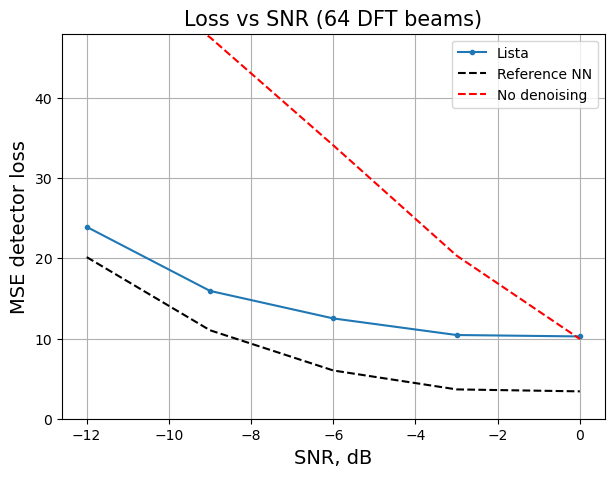

In [29]:
reference = [20.1498, 11.0312,6.0139, 3.6551, 3.4109 ]
noise = [57.8161, 47.5496, 34.0860, 20.339, 9.9376]
SNR_range = range(-12,1,3)
lista_beam_net_1 = [22.4750, 11.875, 6.335, 3.123, 2.094]
lista_beam_net_2 = [21.1612, 10.924, 6.216, 3.526, 3.194]

import matplotlib.pyplot as plt
plt.style.use("default")

plt.figure(figsize=(7,5))
plt.plot(SNR_range,detector_error_beam_net_1,'.-' ,label = 'Lista')
plt.plot(SNR_range,reference,'--k',label = 'Reference NN' )
plt.plot(SNR_range,noise,'--r',label = 'No denoising' )

plt.legend()
plt.title("Loss vs SNR (64 DFT beams)", fontsize = 15)
plt.xlabel("SNR, dB" , fontsize = 14)
plt.ylabel("MSE detector loss", fontsize = 14);
plt.ylim([0 , 48])
plt.grid()


plt.show()

In [18]:
from torchviz import make_dot, make_dot_from_trace

In [36]:
# x = torch.rand(64,48) + 1j*torch.rand(64,48)
# dot = make_dot(l(x), params=dict(l.named_parameters()), show_attrs=True, show_saved=True)
# dot.format = 'png'
# dot.render('model_image')

'model_image.png'

In [11]:
lista_beam =torch.tensor([21.1612, 10.924, 6.216, 3.526, 3.194])

torch.save(lista_beam, 'results/lista_Beam_net.pt')

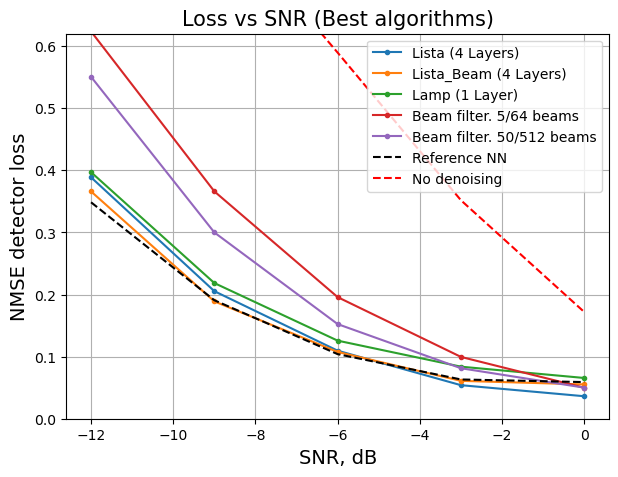

In [66]:
import matplotlib.pyplot as plt
plt.style.use("default")

norma = 57.8161

plt.figure(figsize=(7,5))
plt.plot(SNR_range, np.array(torch.load('results/lista_beam_net.pt'))/norma,'.-' ,label = 'Lista (4 Layers)')
plt.plot(SNR_range,np.array(torch.load('results/lista_Beam_net.pt'))/norma,'.-' ,label = 'Lista_Beam (4 Layers)')
plt.plot(SNR_range,np.array(torch.load('results/lamp.pt'))/norma,'.-' ,label = 'Lamp (1 Layer)')
plt.plot(SNR_range,np.array(torch.load('results/beams_5_of_64.pt'))/norma,'.-' ,label = 'Beam filter. 5/64 beams')
plt.plot(SNR_range,np.array(torch.load('results/beams_50_of_512.pt'))/norma,'.-' ,label = 'Beam filter. 50/512 beams')

plt.plot(SNR_range,np.array(reference)/norma,'--k',label = 'Reference NN' )
plt.plot(SNR_range,np.array(noise)/norma,'--r',label = 'No denoising' )

plt.legend()
plt.title("Loss vs SNR (Best algorithms)", fontsize = 15)
plt.xlabel("SNR, dB" , fontsize = 14)
plt.ylabel("NMSE detector loss", fontsize = 14);
plt.ylim([0 , 0.62])
plt.grid()


plt.show()

In [1]:
import torch

In [18]:
def function(x,s1=1,s2=1):
    one = torch.tensor([1])
    res = one/(1+torch.exp(-s1*x+s2))
    return res
    

In [16]:
def grad(f):
    def result(x):
        x_ = x.detach().requires_grad_(True) 
        f(x_).backward()
        return x_.grad
    return result


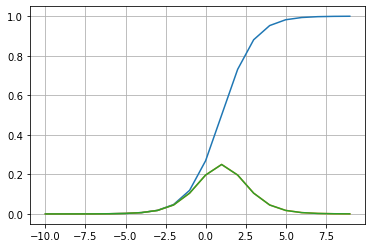

In [41]:
x = torch.arange(-10,10,dtype=torch.float32, requires_grad=True)
y = function(x,1,1)
dydx = function(x,1,1)*(1-function(x,1,1))
y.sum().backward()


with torch.no_grad():
    plt.plot(x,y)
    plt.plot(x,x.grad)
    plt.plot(x,dydx)
    plt.grid()

In [27]:
def sigmoid(r, S1, S2, recived):
    one = torch.tensor([1])
    res = one/(1+torch.exp(-S1*r+S2))
    res = torch.reshape(res, (1, 512))
    res = res.expand((recived, 512))
    return res


In [60]:
r = torch.rand(512,1)
r.shape

torch.Size([512, 1])

In [44]:
one = torch.tensor([1])
res = one/(1+torch.exp(-1*r+1))

In [80]:
s=sigmoid()

In [82]:
(s(r,1,1,48) == s.derivative(r,1,1,48)).all()

forward
backward


tensor(True)

In [76]:
from abc import ABC, abstractmethod

class Activation(ABC):
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
        #return super().__call__(*args, **kwds)

    @abstractmethod
    def forward(self, *args, **kwargs):
        pass

    @abstractmethod
    def derivative(self,*args, **kwargs):
        pass



In [79]:
class sigmoid(Activation):
    #def __call__(self, *args, **kwds):
    #   return self.function(*args,**kwds)
        
    def forward(self, r, S1, S2, recived):
        print('forward')
        one = torch.tensor([1])
        res = one/(1+torch.exp(-S1*r+S2))
        res = torch.reshape(res, (1, 512))
        res = res.expand((recived, 512))
        return res
    
    def derivative(self, r, S1, S2, recived):
        print('backward')
        one = torch.tensor([1])
        res = one/(1+torch.exp(-S1*r+S2))
        res = torch.reshape(res, (1, 512))
        res = res.expand((recived, 512))
        return res
    

In [7]:
x = torch.rand(10)+ 1j*torch.rand(10)

In [87]:
abs(x)**2

tensor([0.1271, 0.0162, 0.0541, 0.7501, 0.0529, 0.9845, 1.1881, 1.0215, 1.1273,
        0.7761])

In [1]:
cd ..

/home/alex/GitHub/ML_for_channel_estimation


In [2]:
import torch
%pylab inline
from ch_est_net.activation import *

Populating the interactive namespace from numpy and matplotlib


In [12]:
def funct(x):
    return torch.sin(x)

In [4]:
sigma_avg = Sigmoid_avg()
sigma = Sigmoid()

In [8]:
import torch 

def grad(f):
    def result(x, *args):
        # make leaf variables out of the inputs
        x_ = x.detach().requires_grad_(True)
        f(x_,*args).sum().backward()
        return x_.grad
    return result



In [5]:
A = torch.linspace(0,2*np.pi,512).reshape(512,1) @ torch.ones(1,64) 

In [6]:
for i in range(64):
    A[:,i] = A[:,i]*i 

In [9]:
x = torch.rand(512,64)
yy = grad_torch(sigma.forward)(x,1,1)
yy1 = grad_torch(sigma_avg.forward)(x,1,1)

In [37]:
A.requires_grad_(True)

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 1.2296e-02, 2.4592e-02,  ..., 7.5005e-01, 7.6234e-01,
         7.7464e-01],
        [0.0000e+00, 2.4592e-02, 4.9183e-02,  ..., 1.5001e+00, 1.5247e+00,
         1.5493e+00],
        ...,
        [0.0000e+00, 6.2586e+00, 1.2517e+01,  ..., 3.8177e+02, 3.8803e+02,
         3.9429e+02],
        [0.0000e+00, 6.2709e+00, 1.2542e+01,  ..., 3.8252e+02, 3.8880e+02,
         3.9507e+02],
        [0.0000e+00, 6.2832e+00, 1.2566e+01,  ..., 3.8327e+02, 3.8956e+02,
         3.9584e+02]], requires_grad=True)

In [13]:
# def f(*args, **kwargs):
    
#     list_args = []
#     dict_kwargs = {}
    
#     for arg in args:
#         if torch.is_tensor(arg):
#             arg = arg.detach()
#         list_args.append(arg)
    

#     for key, value in kwargs.items():
#         if torch.is_tensor(value):
#             value = value.detach()    
#         dict_kwargs[key] = value

#     return dict_kwargs


def grad_torch(f):
    def result(x, *args, **kwargs):
        x_ = x.detach().requires_grad_(True) # make leaf variables out of the inputs

        list_args = []
        dict_kwargs = {}

        for arg in args:
            if torch.is_tensor(arg):
                arg = arg.detach()
            list_args.append(arg)
    
        for key, value in kwargs.items():
            if torch.is_tensor(value):
                value = value.detach()    
            dict_kwargs[key] = value
            
        f(x_,*args).sum().backward()
        return x_.grad
    return result